## 1) Notebook Setup

Install required libraries (uncomment and run if you need to install in this environment).

In [2]:
# If you need to install packages, uncomment and run the following (PowerShell / pip):
%pip install --upgrade pip
%pip install tensorflow pandas numpy matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import statements used throughout the notebook.

In [ ]:
import os
import json
import re
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.20.0


## 2) Load My Dataset

Load the combined Taglish CSV produced by the preprocessing pipeline: `data/combined_taglish.csv`. The notebook will check that file exists and show basic info.

In [4]:
DATA_PATH = Path('../data/combined_taglish.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Expected dataset at {DATA_PATH}. Please generate or place `combined_taglish.csv` in the `data/` folder.')

df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('\nColumns:', list(df.columns))

# show distribution of star ratings if rating column exists
if 'rating' in df.columns:
    print('\nRating value counts (1-5):')
    print(df['rating'].value_counts().sort_index())
else:
    print('\nNo `rating` column found. Please ensure CSV contains a `rating` column with values 1..5')

display(df.head())

Shape: (92262, 5)

Columns: ['text', 'rating', 'original_label', 'source', 'label_3class']

Rating value counts (1-5):
rating
1    17273
2    26513
3     4745
4     6347
5    37384
Name: count, dtype: int64


,text,rating,original_label,source,label_3class
0,appearance10\nquality10\nsuitability10\n\nthis...,5,5.0,data/hf_letijo03.csv,2
1,suitabilityexcellent\nqualityexcellent\nappear...,5,5.0,data/hf_letijo03.csv,2
2,suitabilityvery good\nappearancevery good\nqua...,5,5.0,data/hf_letijo03.csv,2
3,suitabilityvery good for heavy tints\nappearan...,5,5.0,data/hf_letijo03.csv,2
4,appearanceperfect\nqualitygood quality\nsuitab...,5,5.0,data/hf_letijo03.csv,2


Explanation: the `rating` column should contain integers from 1 to 5. We will convert these to labels 0..4 later.

## 3) Preprocessing (from scratch)

All preprocessing steps are implemented here with clear separate cells: lowercasing, emoji/special char removal, repeated-letter normalization, punctuation cleaning, stopword removal (Tagalog + English), tokenization, label conversion, padding, and train/test split.

### 3.1 Lowercasing and basic cleanup

In [5]:
# Work on a copy
data = df.copy()
# Ensure text column exists; try common names
TEXT_COL = None
for c in ['text','review','content','comment']:
    if c in data.columns:
        TEXT_COL = c
        break
if TEXT_COL is None:
    # fallback to first text-like column
    TEXT_COL = data.columns[0]
    print(f'Using `{TEXT_COL}` as text column')

data['text_raw'] = data[TEXT_COL].astype(str)
data['text'] = data['text_raw'].str.lower()

display(data[['text_raw','text']].head())

,text_raw,text
0,appearance10\nquality10\nsuitability10\n\nthis...,appearance10\nquality10\nsuitability10\n\nthis...
1,suitabilityexcellent\nqualityexcellent\nappear...,suitabilityexcellent\nqualityexcellent\nappear...
2,suitabilityvery good\nappearancevery good\nqua...,suitabilityvery good\nappearancevery good\nqua...
3,suitabilityvery good for heavy tints\nappearan...,suitabilityvery good for heavy tints\nappearan...
4,appearanceperfect\nqualitygood quality\nsuitab...,appearanceperfect\nqualitygood quality\nsuitab...


### 3.2 Remove emojis and non-text symbols

In [6]:
# Regex to remove most emojis and pictographs
emoji_pattern = re.compile("[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF]+", flags=re.UNICODE)

def remove_emojis(text):
    try:
        return emoji_pattern.sub(r'', text)
    except Exception:
        return text

data['text'] = data['text'].apply(remove_emojis)
display(data['text'].head())

0    appearance10\nquality10\nsuitability10\n\nthis...
1    suitabilityexcellent\nqualityexcellent\nappear...
2    suitabilityvery good\nappearancevery good\nqua...
3    suitabilityvery good for heavy tints\nappearan...
4    appearanceperfect\nqualitygood quality\nsuitab...
Name: text, dtype: object

In [7]:
def normalize_repeats(text):
    # replace 3 or more repeats of a character with two repeats
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

data['text'] = data['text'].apply(normalize_repeats)
display(data['text'].head())

0    appearance10\nquality10\nsuitability10\n\nthis...
1    suitabilityexcellent\nqualityexcellent\nappear...
2    suitabilityvery good\nappearancevery good\nqua...
3    suitabilityvery good for heavy tints\nappearan...
4    appearanceperfect\nqualitygood quality\nsuitab...
Name: text, dtype: object

### 3.4 Clean punctuation and unwanted characters

In [8]:
# Keep letters, numbers and simple punctuation; remove URLs and extra whitespace
url_regex = re.compile(r'http\S+|www\\.\S+')
def clean_text(text):
    text = url_regex.sub(' ', text)
    # replace non-alphanumeric (except spaces) with space
    text = re.sub(r'[^0-9a-zA-Z\u00C0-\u024F\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['text'] = data['text'].apply(clean_text)
display(data['text'].head())

0    appearance10 quality10 suitability10 this prod...
1    suitabilityexcellent qualityexcellent appearan...
2    suitabilityvery good appearancevery good quali...
3    suitabilityvery good for heavy tints appearanc...
4    appearanceperfect qualitygood quality suitabil...
Name: text, dtype: object

### 3.5 Remove stopwords (Tagalog + English)
We'll use small built-in lists for Tagalog and English stopwords to avoid external downloads. You can expand these lists later.

In [9]:
EN_STOPWORDS = set([
    'a','an','the','and','or','but','if','while','is','are','am','was','were','be','been','has','have','had','do','does','did',
    'this','that','these','those','for','on','in','at','by','with','as','of','to','from','not','no','yes','it','its','i','you','he','she','we','they','them','me','my','our','your'
])
TL_STOPWORDS = set([
    'ang','sa','ng','mga','si','ni','ito','iyon','yon','ay','na','pa','may','wala','ako','ikaw','ka','kami','kita','kayo','nila','natin','atin','dahil','kasi','pero','o','at','saka','lamang','lang','rin','din','ba','muna','po','ho'
])
STOPWORDS = EN_STOPWORDS.union(TL_STOPWORDS)

def remove_stopwords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)

data['text_nostop'] = data['text'].apply(remove_stopwords)
display(data[['text','text_nostop']].head())

,text,text_nostop
0,appearance10 quality10 suitability10 this prod...,appearance10 quality10 suitability10 product d...
1,suitabilityexcellent qualityexcellent appearan...,suitabilityexcellent qualityexcellent appearan...
2,suitabilityvery good appearancevery good quali...,suitabilityvery good appearancevery good quali...
3,suitabilityvery good for heavy tints appearanc...,suitabilityvery good heavy tints appearancesma...
4,appearanceperfect qualitygood quality suitabil...,appearanceperfect qualitygood quality suitabil...


### 3.6 Tokenize using Keras Tokenizer and prepare sequences

In [10]:
# Prepare texts and labels
texts = data['text_nostop'].astype(str).tolist()
# Convert ratings 1-5 to labels 0-4 if rating exists
if 'rating' in data.columns:
    labels = data['rating'].astype(int).apply(lambda x: x-1).clip(0,4).values
else:
    raise ValueError('Dataset must contain `rating` column with values 1..5')

# Tokenizer settings
vocab_size = 8000
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Choose maxlen as 95th percentile of lengths or cap at 100
seq_lens = [len(s) for s in sequences]
maxlen = int(np.percentile(seq_lens, 95))
maxlen = min(maxlen, 100)
print('Chosen maxlen=', maxlen)
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = to_categorical(labels, num_classes=5)

print('X shape:', X.shape)
print('y shape:', y.shape)

Chosen maxlen= 38
X shape: (92262, 38)
y shape: (92262, 5)
X shape: (92262, 38)
y shape: (92262, 5)


### 3.7 Train/Test split

In [11]:
# Stratify by label to keep class balance
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, data.index.values, test_size=0.15, random_state=42, stratify=labels)

print('Train X:', X_train.shape, 'Test X:', X_test.shape)

Train X: (78422, 38) Test X: (13840, 38)


## 4) Build the RNN Model

We build a simple Embedding + LSTM network with a small Dense head. No pretrained components are used.

In [12]:
embedding_dim = 128
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import backend as K

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(GRU(32, dropout=0.5, recurrent_dropout=0.3, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Focal loss implementation
def focal_loss(gamma=2.0, alpha=None):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        if alpha is None:
            weight = K.pow(1 - y_pred, gamma)
        else:
            # alpha can be scalar or per-class array
            alpha_t = K.constant(alpha, dtype=K.floatx())
            weight = alpha_t * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss_fn

# Use a lower learning rate to stabilize training
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=focal_loss(gamma=2.0, alpha=None), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5) Train the Model

Train for a small number of epochs (5–10). Use validation split of 0.1 on the training set.

In [13]:
epochs = 6
batch_size = 128

# Create an explicit stratified validation set from X_train to ensure stable validation
y_train_full_int = np.argmax(y_train, axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train_full_int)

# === Oversample minority classes (2 and 3) in X_train to improve recall ===
from sklearn.utils import class_weight
import numpy as _np

y_train_int = np.argmax(y_train, axis=1)
unique, counts = np.unique(y_train_int, return_counts=True)
count_map = dict(zip(unique, counts))
print('Train class counts before oversampling:', count_map)
# target: match class 1 count (balanced oversample)
class1_count = int(count_map.get(1, max(count_map.values())))
target = int(class1_count)
print('Oversample target (match class1):', target)
# collect indices per class
indices = {c: _np.where(y_train_int == c)[0] for c in unique}
to_add_idx = []
from numpy.random import default_rng
rng = default_rng(42)
for cls in [2,3]:
    cur = len(indices.get(cls, []))
    if cur < target and cur > 0:
        need = target - cur
        samples = rng.choice(indices[cls], size=need, replace=True)
        to_add_idx.extend(samples.tolist())

if len(to_add_idx) > 0:
    X_train = _np.vstack([X_train, X_train[to_add_idx]])
    y_train = _np.vstack([y_train, y_train[to_add_idx]])
    print('Added', len(to_add_idx), 'samples to X_train')
else:
    print('No oversampling required')

# Recompute class weights after oversampling
y_train_int = np.argmax(y_train, axis=1)
classes = _np.unique(y_train_int)
class_weights_vals = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train_int)
class_weights = {int(c): float(w) for c,w in zip(classes, class_weights_vals)}
print('Train class counts after oversampling:', dict(zip(classes, _np.bincount(y_train_int))))
print('Class weights after oversampling:', class_weights)

# After oversampling, compute class weights for training and pass to fit
y_train_int = np.argmax(y_train, axis=1)
classes = _np.unique(y_train_int)
class_weights_vals = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train_int)
class_weights = {int(c): float(w) for c,w in zip(classes, class_weights_vals)}
print('Class weights after oversampling:', class_weights)
# Compile with categorical_crossentropy; we'll pass class_weights to fit
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: EarlyStopping + ReduceLROnPlateau to stabilize training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
callbacks = [early_stop, reduce_lr]

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1,
    class_weight=class_weights,
    callbacks=callbacks,
)


Train class counts before oversampling: {np.int64(0): np.int64(13214), np.int64(1): np.int64(20282), np.int64(2): np.int64(3630), np.int64(3): np.int64(4855), np.int64(4): np.int64(28598)}
Oversample target (match class1): 20282
Added 32079 samples to X_train
Train class counts after oversampling: {np.int64(0): np.int64(13214), np.int64(1): np.int64(20282), np.int64(2): np.int64(20282), np.int64(3): np.int64(20282), np.int64(4): np.int64(28598)}
Class weights after oversampling: {0: 1.5537762978658998, 1: 1.0123064786510205, 2: 1.0123064786510205, 3: 1.0123064786510205, 4: 0.7179383173648507}
Class weights after oversampling: {0: 1.5537762978658998, 1: 1.0123064786510205, 2: 1.0123064786510205, 3: 1.0123064786510205, 4: 0.7179383173648507}
Epoch 1/6
Epoch 1/6
803/803 ━━━━━━━━━━━━━━━━━━━━ 114s 125ms/step - accuracy: 0.2378 - loss: 1.6084 - val_accuracy: 0.5453 - val_loss: 1.5665 - learning_rate: 5.0000e-05
Epoch 2/6
803/803 ━━━━━━━━━━━━━━━━━━━━ 114s 125ms/step - accuracy: 0.2378 - loss:

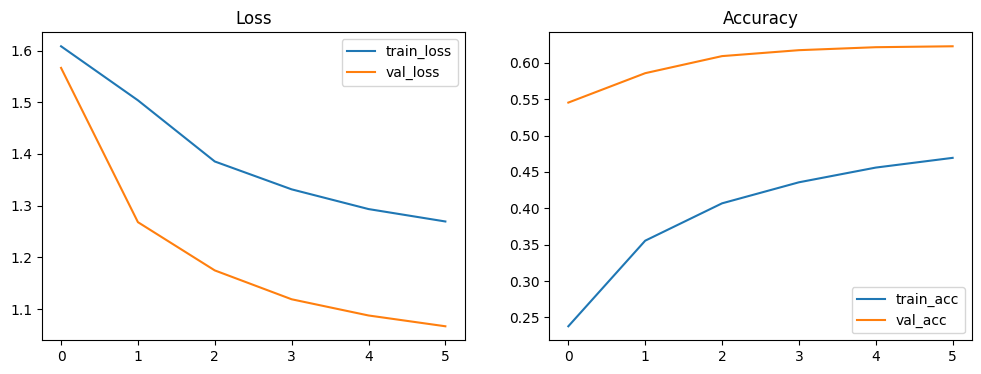

In [14]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

## 6) Evaluate the Model

Generate predictions on the held-out test set, show a classification report and confusion matrix.

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
Classification report:
              precision    recall  f1-score   support

           0     0.6063    0.7727    0.6795      2591
           1     0.6132    0.5577    0.5841      3977
           2     0.1414    0.2584    0.1828       712
           3     0.1861    0.1660    0.1755       952
           4     0.8535    0.7261    0.7847      5608

    accuracy                         0.6238     13840
   macro avg     0.4801    0.4962    0.4813     13840
weighted avg     0.6556    0.6238    0.6345     13840

Classification report:
              precision    recall  f1-score   support

           0     0.6063    0.7727    0.6795      2591
           1     0.6132    0.5577    0.5841      3977
           2     0.1414    0.2584    0.1828       712
           3     0.1861    0.1660    0.1755       952
           4     0.8535    0.7261    0.7847      5608

    accuracy                         0.6238     13840
   ma

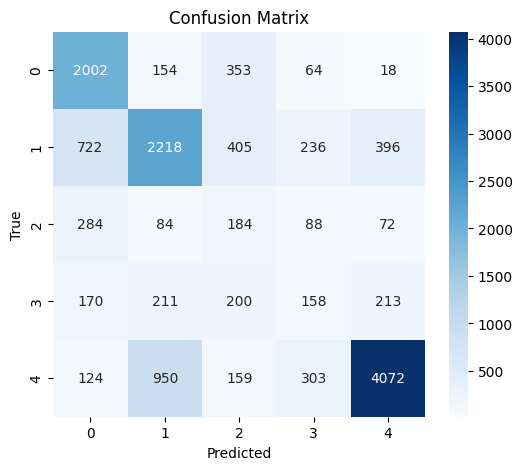

In [15]:
y_pred_probs = model.predict(X_test, batch_size=256)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print('Classification report:')
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Interpretation: inspect precision/recall for each rating class and common confusions in the matrix.

## 7) Export Results

Save the trained model and tokenizer to disk. Optionally save the processed dataset (tokenized sequences).

In [16]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)
model_path = ARTIFACTS_DIR / 'taglish_rnn_model.h5'
tokenizer_path = ARTIFACTS_DIR / 'tokenizer.pickle'
sequences_path = ARTIFACTS_DIR / 'sequences.npy'
labels_path = ARTIFACTS_DIR / 'labels.npy'

model.save(str(model_path))
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
np.save(sequences_path, X)
np.save(labels_path, labels)

print('Saved model to', model_path)
print('Saved tokenizer to', tokenizer_path)
print('Saved processed sequences/labels to artifacts folder')

Saved model to artifacts\taglish_rnn_model.h5
Saved tokenizer to artifacts\tokenizer.pickle
Saved processed sequences/labels to artifacts folder


# Quick Prediction (Test your own inputs)

Use the cell below to type a Tagalog/Taglish review and get a predicted 1–5 rating plus a Good/Neutral/Bad mapping. Edit the `SAMPLE` variable or run the cell and paste your text when prompted.

In [17]:
# You can set SAMPLE to a string here, or leave as None to be prompted at runtime
SAMPLE = None  # e.g. "It's legit pero I think yung pera could get something better, hindi yung ganito"

# Try common artifact locations (notebooks/artifacts, ./artifacts, ../notebooks/artifacts)
candidates = [Path('artifacts'), Path('notebooks') / 'artifacts', Path('.') / 'notebooks' / 'artifacts', Path('..') / 'notebooks' / 'artifacts']
ART = next((p for p in candidates if p.exists()), Path('artifacts'))
model_path = ART / 'taglish_rnn_model.h5'
tokenizer_path = ART / 'tokenizer.pickle'
sequences_path = ART / 'sequences.npy'

if not model_path.exists() or not tokenizer_path.exists():
    print('Could not find saved model/tokenizer in expected artifact locations:')
    for p in candidates:
        print(' -', p)
    raise FileNotFoundError('Please run the Export Results cell to save model/tokenizer to the artifacts folder first.')

# Load tokenizer and model (compile=False to avoid custom loss requirements)
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)
model = tf.keras.models.load_model(str(model_path), compile=False)

# Determine maxlen from saved sequences if available
if sequences_path.exists():
    try:
        seqs = np.load(str(sequences_path), allow_pickle=True)
        if hasattr(seqs, 'shape') and len(seqs.shape) >= 2:
            maxlen = int(seqs.shape[1])
        else:
            maxlen = 38
    except Exception:
        maxlen = 38
else:
    maxlen = 38

# Preprocessing utilities (kept consistent with notebook)
emoji_pattern = re.compile("[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF]+", flags=re.UNICODE)

def remove_emojis(text):
    try:
        return emoji_pattern.sub('', text)
    except Exception:
        return text

def normalize_repeats(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

url_regex = re.compile(r'http\S+|www\\.\S+')

def clean_text(text):
    text = url_regex.sub(' ', text)
    text = re.sub(r'[^0-9a-zA-Z\u00C0-\u024F\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

EN_STOPWORDS = set(['a','an','the','and','or','but','if','while','is','are','am','was','were','be','been','has','have','had','do','does','did','this','that','these','those','for','on','in','at','by','with','as','of','to','from','not','no','yes','it','its','i','you','he','she','we','they','them','me','my','our','your'])
TL_STOPWORDS = set(['ang','sa','ng','mga','si','ni','ito','iyon','yon','ay','na','pa','may','wala','ako','ikaw','ka','kami','kita','kayo','nila','natin','atin','dahil','kasi','pero','o','at','saka','lamang','lang','rin','din','ba','muna','po','ho'])
STOPWORDS = EN_STOPWORDS.union(TL_STOPWORDS)

def remove_stopwords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)

# Get input text
if SAMPLE is None:
    try:
        SAMPLE = input('Enter text to classify: ')
    except Exception:
        SAMPLE = ''
text = str(SAMPLE).strip()
if len(text) == 0:
    print('No input provided; set SAMPLE variable and re-run the cell.')
else:
    # Preprocess
    t = text.lower()
    t = remove_emojis(t)
    t = normalize_repeats(t)
    t = clean_text(t)
    t = remove_stopwords(t)
    seq = tokenizer.texts_to_sequences([t])
    X = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    probs = model.predict(X)
    probs = np.asarray(probs).reshape(-1)
    pred_class = int(np.argmax(probs))
    pred_rating = pred_class + 1
    if pred_rating <= 2:
        three_class = 'Bad'
    elif pred_rating == 3:
        three_class = 'Neutral'
    else:
        three_class = 'Good'
    print('\nInput:', text)
    print('Preprocessed:', t)
    print('Predicted rating (1-5):', pred_rating)
    print('Predicted 3-class (Good/Neutral/Bad):', three_class)
    print('\nPer-class probabilities:')
    for i,p in enumerate(probs):
        print(f'  {i+1}-star: {p:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Input: "it was great but it's limited time only sayang naman"
Preprocessed: great s limited time only sayang naman
Predicted rating (1-5): 4
Predicted 3-class (Good/Neutral/Bad): Good

Per-class probabilities:
  1-star: 0.1251
  2-star: 0.2432
  3-star: 0.2306
  4-star: 0.2683
  5-star: 0.1327

Input: "it was great but it's limited time only sayang naman"
Preprocessed: great s limited time only sayang naman
Predicted rating (1-5): 4
Predicted 3-class (Good/Neutral/Bad): Good

Per-class probabilities:
  1-star: 0.1251
  2-star: 0.2432
  3-star: 0.2306
  4-star: 0.2683
  5-star: 0.1327
